### Setup

In [1]:
import os, sys
HOME = os.environ['HOME']  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [2]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
%load_ext autoreload
%autoreload 2

Syntax warning: Unbound global variable in /usr/share/gap/pkg/browse/PackageIn\
fo.g:73
  if not IsKernelExtensionAvailable("Browse", "ncurses") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/edim/PackageInfo\
.g:60
  if not IsKernelExtensionAvailable("EDIM","ediv") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^


In [3]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
MODEL_DIR = '2024-08-16_22-53-29_SL2_5_MLP3_256'
# MODEL_DIR = '2024-08-14_21-24-30_gapS_5_'
# MODEL_DIR = '2024-08-27_16-32-46_Dic30_MLP3_128'
# MODEL_DIR = '2024-08-27_23-16-05_F11_MLP3_256'
# MODEL_DIR = '2024-09-02_18-17-20_smallgrp_54_8_MLP3_256_0_6'
# MODEL_DIR = '2024-09-05_15-22-58_smallgrp_54_8_MLP3_1024_0_6'
# MODEL_DIR = '2024-09-05_20-47-44_smallgrp_54_8_MLP3_1024_0_6_wd1e-6'
# MODEL_DIR = '2024-09-02_18-51-29_smallgrp_96_71_MLP3_256_0_6'
# MODEL_DIR = '2024-09-03_17-28-20_smallgrp_192_1025_MLP3_512_0_6'
# MODEL_DIR = '2024-09-03_21-09-07_Z_59_128'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir)
data = GroupData(params)
group = data.groups[0]

Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: smallgrp(120, 5)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)


/home/wilson/Finite-groups/src/model_utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


`models` (returned from `load_models`) is a list of InstancedModule objects, one for each training checkpoint that we chose to save. For most runs, we only save the final checkpoints, so `len(models)==1`

For efficiency during training, the InstancedModule object contains 100 different instances starting from different random initializations. 

Here, we look only at the one with best test accuracy.

In [4]:
loss_dict = test_loss(models[-1].to(device), data)

In [5]:
instance = loss_dict['G0_acc'].argmax().item()
# instance = loss_dict['G0_loss'].argmin().item()
# instance = (loss_dict['G0_acc'] == 1).nonzero()[3]
print(loss_dict[f'G0_loss'][instance], loss_dict[f'G0_acc'][instance], instance)
model = models[-1][instance].to(device)

tensor(0.0836) tensor(0.9999) 55


`MLP3` architecture is
$$f(z\mid x, y) = W_u(z)\cdot\text{ReLU}[W_h(W_l(x)+W_r(y))]] = \sum_i w_u^i(z) \text{ReLU}[w_l^i(x)+w_r^i(y)]$$
where $w_u^i, w_l^i, w_r^i\in\mathbb{R}^G$ are the columns of $W_u, (W_hW_l)^{\top}, (W_hW_r)^{\top}$ respectively.

In [6]:
COMPLEX = False

# model.get_neurons() folds the linear map into the embeddings
lneurons, rneurons = model.get_neurons()
uneurons = model.unembedding.data.detach()
lneurons, rneurons, uneurons = lneurons.squeeze(0).to('cpu'), rneurons.squeeze(0).to('cpu'), uneurons.squeeze(0).to('cpu').T
if COMPLEX:
    lneurons = t.complex(lneurons, t.zeros_like(lneurons))
    rneurons = t.complex(rneurons, t.zeros_like(rneurons))
    uneurons = t.complex(uneurons, t.zeros_like(uneurons))
# lneurons = t.complex(t.zeros_like(lneurons), lneurons)
# rneurons = t.complex(t.zeros_like(rneurons), rneurons)
# uneurons = t.complex(t.zeros_like(uneurons), uneurons)
lneurons.shape, rneurons.shape, uneurons.shape

(torch.Size([120, 256]), torch.Size([120, 256]), torch.Size([120, 256]))

In [155]:
def ablate_loss(ln, rn, un):
    ablate_model = copy.deepcopy(model)
    ablate_model.linear.data = t.eye(ln.shape[1]).unsqueeze(0)
    ablate_model.embedding_left.data = ln.unsqueeze(0)
    ablate_model.embedding_right.data = rn.unsqueeze(0)
    ablate_model.unembedding.data = un.unsqueeze(0).mT
    return test_loss(ablate_model.to(device), data)

def ablate_idx_loss(idxs):
    ln, rn= model.get_neurons()
    un = model.unembedding.data.detach()
    ln, rn, un = ln.squeeze(0).to('cpu'), rn.squeeze(0).to('cpu'), un.squeeze(0).to('cpu').T
    ln, rn, un = ln[:, idxs], rn[:, idxs], un[:, idxs]
    return ablate_loss(ln, rn, un)

### Neurons are irrep-sparse

I.e., each neuron is a linear combination of matrix entries of some irrep.

That is, for each $i$, there exists an irrep $\rho_i\colon G\to\text{GL}(\mathbb{R}^d)$ such that, for some $A_i,B_i,C_i$,
$$w_l^i(x) \approx \text{tr}(\rho_i(x) A_i)$$
$$w_r^i(y) \approx \text{tr}(\rho_i(y) B_i)$$
$$w_u^i(z) \approx \text{tr}(\rho_i(z) C_i)$$

(This was first noticed by Chughtai et al.)

**Notation**: 4d-0 is the 1st degree 4 irrep, 4d-1 is the 2nd, etc. Ordering is arbitrary but is consistent between runs (I think)

In [7]:
if COMPLEX:
    irreps = group.get_complex_irreps()
else:
    irreps = group.get_real_irreps(verbose=True)
print(irreps.keys())

Complex irrep 2d-0 -> real irrep 4d-0
Complex irrep 2d-1 -> real irrep 4d-1
Complex irrep 4d-1 -> real irrep 8d-0
Complex irrep 6d-0 -> real irrep 12d-0
dict_keys(['1d-0', '4d-0', '4d-1', '3d-0', '3d-1', '4d-2', '8d-0', '5d-0', '12d-0'])


In [8]:
# Get orthogonal basis for each irrep
irrep_bases = dict()
for name, irrep in irreps.items():
    irrep = einops.rearrange(irrep, 'N d1 d2 -> N (d1 d2)')
    U, S, V = t.svd(irrep)
    nonzero = S > 1e-5
    irrep_bases[name] = U[:,nonzero]

# Dimension of subspace spanned by each irrep
for k, v in irrep_bases.items():
    print(k, v.shape)

1d-0 torch.Size([120, 1])
4d-0 torch.Size([120, 4])
4d-1 torch.Size([120, 4])
3d-0 torch.Size([120, 9])
3d-1 torch.Size([120, 9])
4d-2 torch.Size([120, 16])
8d-0 torch.Size([120, 16])
5d-0 torch.Size([120, 25])
12d-0 torch.Size([120, 36])


In [9]:
# Proportion of variance explained by each irrep, for each neuron
lexpl, rexpl, uexpl = dict(), dict(), dict()

for name, basis in irrep_bases.items():
    lproj = basis.T @ lneurons
    lexpl[name] = (basis.H @ lneurons).norm(dim=0)**2 / (lneurons.norm(dim=0)**2 + 1e-8)
    rexpl[name] = (basis.H @ rneurons).norm(dim=0)**2 / (rneurons.norm(dim=0)**2 + 1e-8)
    uexpl[name] = (basis.H @ uneurons).norm(dim=0)**2 / (uneurons.norm(dim=0)**2 + 1e-8)

lexpl_max, lirrep = t.stack(list(lexpl.values()), dim=0).max(dim=0)

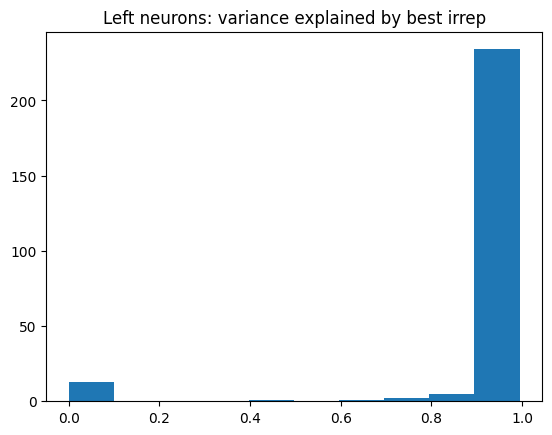

In [10]:
plt.hist(lexpl_max.tolist())
plt.title('Left neurons: variance explained by best irrep')
plt.show()

In [11]:
# Get Frobenius-Schur indicators
# +1 means real irrep. Otherwise, complex.
for name, irrep in irreps.items():
    print(name, group.get_frobenius_schur(irrep))

1d-0 1
4d-0 -2
4d-1 -2
3d-0 1
3d-1 1
4d-2 1
8d-0 -2
5d-0 1
12d-0 -2


In [17]:
irrep_idx_dict = {
    name: [
        i for i in range(lneurons.shape[-1]) 
        if lexpl[name][i].item() > 0.95 and lneurons[:,i].norm() > 1e-2
    ]
    for name in irreps
}
irrep_idx_dict['none'] = [
    i for i in range(lneurons.shape[-1])
    if all(lexpl[name][i].item() <= 0.95 for name in irreps)
]
for k, v in irrep_idx_dict.items():
    print(k, len(v))

1d-0 0
4d-0 0
4d-1 112
3d-0 28
3d-1 48
4d-2 2
8d-0 0
5d-0 0
12d-0 0
none 63


In [161]:
print(ablate_idx_loss(irrep_idx_dict['4d-1']))
print(ablate_idx_loss(irrep_idx_dict['3d-0']))
print(ablate_idx_loss(irrep_idx_dict['3d-1']))
print(ablate_idx_loss(irrep_idx_dict['4d-1'] + irrep_idx_dict['3d-0'] + irrep_idx_dict['3d-1'] + irrep_idx_dict['4d-2']))
print(ablate_idx_loss(irrep_idx_dict['4d-1'] + irrep_idx_dict['3d-0'] + irrep_idx_dict['3d-1'] + irrep_idx_dict['4d-2'] + irrep_idx_dict['none']))
print(ablate_idx_loss(list(range(lneurons.shape[-1]))))

{'G0_loss': tensor([3.2155]), 'G0_acc': tensor([0.1637])}
{'G0_loss': tensor([4.2444]), 'G0_acc': tensor([0.0283])}
{'G0_loss': tensor([3.2640]), 'G0_acc': tensor([0.1391])}
{'G0_loss': tensor([1.0786]), 'G0_acc': tensor([0.7616])}
{'G0_loss': tensor([0.0836]), 'G0_acc': tensor([0.9999])}


4d-1


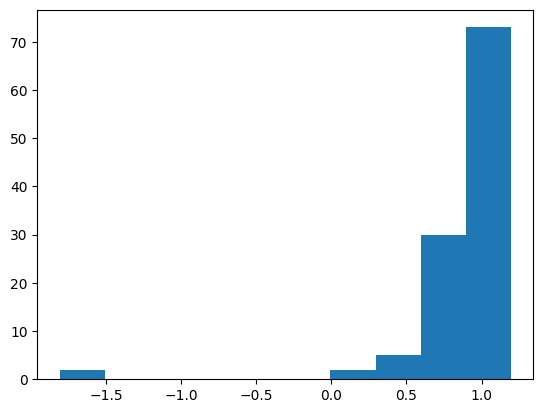

3d-0


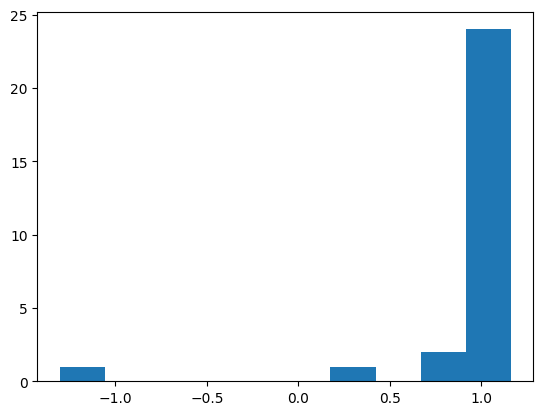

3d-1


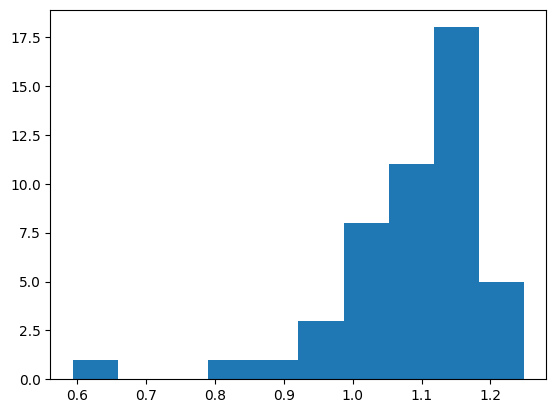

4d-2


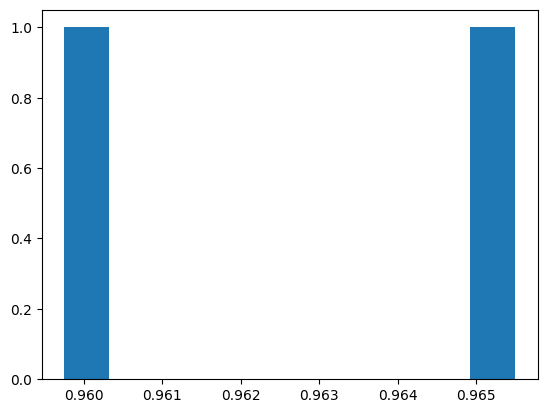

none


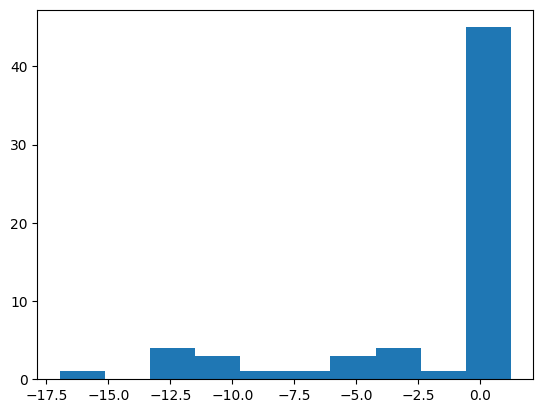

In [20]:
for k, v in irrep_idx_dict.items():
    if not v:
        continue
    print(k)
    plt.hist(lneurons[:,irrep_idx_dict[k]].norm(dim=0).log10().tolist())
    plt.show()

In [95]:
irrep_name = '3d-1'
irrep_d = irreps[irrep_name].shape[-1]
irrep = irreps[irrep_name]
irrep_idxs = irrep_idx_dict[irrep_name]
irrep_lneurons = lneurons[:, irrep_idxs]
irrep_rneurons = rneurons[:, irrep_idxs]
irrep_uneurons = uneurons[:, irrep_idxs]
irrep_frobschur = np.sign(group.get_frobenius_schur(irrep)).item()

In [96]:
flat_irrep = einops.rearrange(irrep, 'n d1 d2 -> n (d1 d2)')
rcond = t.linalg.matrix_rank(flat_irrep)
# Project neurons onto subspace spanned by flat_irrep
A_flat = t.linalg.lstsq(flat_irrep, irrep_lneurons, driver='gelsd').solution
B_flat = t.linalg.lstsq(flat_irrep, irrep_rneurons, driver='gelsd').solution
C_flat = t.linalg.lstsq(flat_irrep, irrep_uneurons, driver='gelsd').solution
# A_flat = (t.linalg.inv(flat_irrep.H @ flat_irrep) @ flat_irrep.H @ irrep_lneurons)
# B_flat = (t.linalg.inv(flat_irrep.H @ flat_irrep) @ flat_irrep.H @ irrep_rneurons)
# C_flat = (t.linalg.inv(flat_irrep.H @ flat_irrep) @ flat_irrep.H @ irrep_uneurons)
A = einops.rearrange(A_flat, '(d1 d2) m -> m d1 d2', d1=irrep_d, d2=irrep_d).mH
B = einops.rearrange(B_flat, '(d1 d2) m -> m d1 d2', d1=irrep_d, d2=irrep_d).mH
C = einops.rearrange(C_flat, '(d1 d2) m -> m d1 d2', d1=irrep_d, d2=irrep_d).mH

A_norm = t.linalg.matrix_norm(A)
B_norm = t.linalg.matrix_norm(B)
(A_norm - B_norm).norm()**2 / B_norm.norm()**2
print('A and B norm diff', ((A_norm - B_norm).norm()**2 / B_norm.norm()**2).item())

# Normalize A and B to have unit Frobenius norm
# A = A / A_norm.unsqueeze(1).unsqueeze(1)
# B = B / A_norm.unsqueeze(1).unsqueeze(1)
# C = C * ( (A_norm + B_norm) / 2).unsqueeze(1).unsqueeze(1)

A.shape, B.shape, C.shape

A and B norm diff 0.0001664203155087307


(torch.Size([48, 3, 3]), torch.Size([48, 3, 3]), torch.Size([48, 3, 3]))

### $C_i\approx B_iA_i$

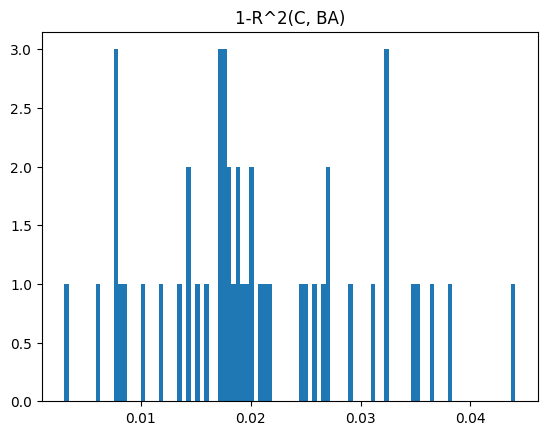

In [97]:
x = einops.rearrange(B @ A, 'm d1 d2 -> m (d1 d2)')
y = einops.rearrange(C, 'm d1 d2 -> m (d1 d2)')
coef = (x.conj() * y).sum(dim=-1) / (x.conj() * x).sum(dim=-1)
yhat = coef.unsqueeze(1) * x
r2 = (yhat - y).norm(dim=-1).pow(2) / y.norm(dim=-1).pow(2)
plt.hist(r2.tolist(), bins=100)
plt.title('1-R^2(C, BA)')
plt.show()
good = r2 < 0.1

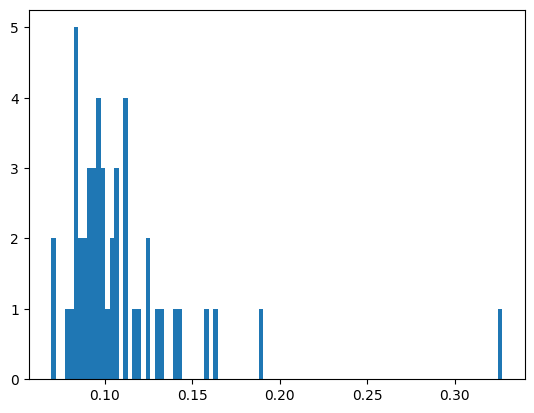

In [98]:
plt.hist(coef[good].tolist(), bins=100)
plt.show()

### $A_i, B_i, C_i$ are low rank

To be specific,
$$
\text{rank}(A)=\text{rank}(B)=\begin{cases}1 & \iota=1 \\ 2 & \iota=0 \\ 4 & \iota=-1,\end{cases}
$$
where $\iota$ is the Frobenius-Schur indicator. (+1 is real irrep, 0 is complex, and -1 is quaternionic.) 

In the real case, we can write
$$A_i\approx a_ib_i^\top$$
$$B_i\approx c_id_i^\top$$
$$C_i\approx A_iB_i\approx \langle b_i, c_i\rangle a_i d_i^\top$$

In [99]:
lU, lS, lV = t.svd(A[1])
lU, lS, lV

(tensor([[-0.2319, -0.9726, -0.0148],
         [ 0.4844, -0.1023, -0.8688],
         [ 0.8436, -0.2086,  0.4949]]),
 tensor([1.9533e+00, 8.2018e-03, 3.6044e-04]),
 tensor([[-0.9109,  0.1117,  0.3972],
         [-0.2855, -0.8656, -0.4114],
         [-0.2979,  0.4881, -0.8204]]))

In [100]:
rank = {
    1: 1,
    0: 2,
    -1: 4
}[irrep_frobschur]

if irrep_frobschur == 1:
    a, b, c, d = [], [], [], []
    for i in range(len(irrep_idxs)):
        lU, lS, lV = t.linalg.svd(A[i])
        rU, rS, rV = t.linalg.svd(B[i])
        a.append(lU[:,0])
        b.append(lV[0])
        c.append(rU[:,0])
        d.append(rV[0])
        assert lS[0]**2 / lS.norm()**2 > 1-1e-2
        assert rS[0]**2 / rS.norm()**2 > 1-1e-2
    a, b, c, d = t.stack(a, dim=0), t.stack(b, dim=0), t.stack(c, dim=0), t.stack(d, dim=0)
    a_sign = t.sgn(a[:,0])
    a = t.diag(a_sign) @ a
    b = t.diag(a_sign) @ b
    d_sign = t.sgn(d[:,0])
    c = t.diag(d_sign) @ c
    d = t.diag(d_sign) @ d
else:
    # Our guess is that left singular vectors of A are const across neurons
    # and same for right singular vectors of B (up to sign, etc)
    # So we use the first neuron to get the relevant singular vectors
    # and share them across all neurons
    lU0 = t.linalg.svd(A[0])[0]
    # rV0 = t.linalg.svd(B[0])[2]
    rV0 = lU0.T
    lUs, lVs, rUs, rVs = [], [], [], []
    for i in range(len(irrep_idxs)):
        print(i)
        lS = t.linalg.svd(A[i])[1]
        rS = t.linalg.svd(B[i])[1]
        assert lS[:rank].norm()**2 / lS.norm()**2 > 1-1e-2
        assert rS[:rank].norm()**2 / rS.norm()**2 > 1-1e-2
        lS_inv, rS_inv = t.zeros_like(lS), t.zeros_like(rS)
        lS_inv[:rank] = 1 / lS[:rank]
        rS_inv[:rank] = 1 / rS[:rank]
        lV = t.diag(lS_inv) @ lU0.T @ A[i]
        rU = B[i] @ rV0.T @ t.diag(rS_inv)
        # check that lV and rU are orthogonal,
        # i.e. that lU0 and rV0 are valid left/right singular vectors
        assert ((lV @ lV.T)[:rank,:rank] - t.eye(rank)).norm() < 1e-2
        assert ((rU.T @ rU)[:rank,:rank] - t.eye(rank)).norm() < 1e-2
        lUs.append(lU0)
        rUs.append(rU)
        lVs.append(lV)
        rVs.append(rV0)

    rUs = t.stack(rUs, dim=0)
    rVs = t.stack(rVs, dim=0)
    lUs = t.stack(lUs, dim=0)
    lVs = t.stack(lVs, dim=0)
    a, b, c, d = lUs[:,:,0], lVs[:,0], rUs[:,:,0], rVs[:,0]
# print(min(A_expl), min(B_expl))

# # Clear up sign ambiguity from SVD
# a_sign = t.sgn(a[:,0])
# a = t.diag(a_sign) @ a
# b = t.diag(a_sign) @ b
# d_sign = t.sgn(d[:,0])
# c = t.diag(d_sign) @ c
# d = t.diag(d_sign) @ d

# # Remove points with bad C=BA r^2
a, b, c, d = a[good], b[good], c[good], d[good]
coef_good = coef[good]

In [121]:
test = t.randn((10, 10))
t.trace(test), einops.einsum(test, 'i i ->')

(tensor(-9.0866), tensor(-9.0866))

In [127]:
trA = einops.einsum(A, 'm i j -> m')
tr_rhoA = einops.einsum(A, irrep[5], 'm i j, i j -> m')

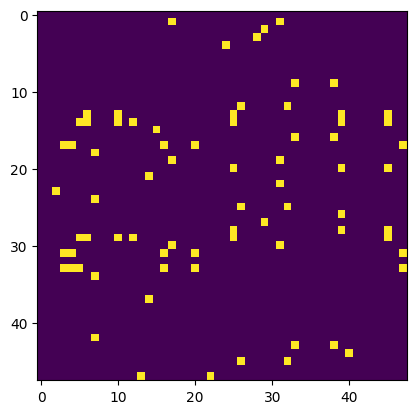

In [138]:
plt.imshow(((trA.unsqueeze(0) - tr_rhoA.unsqueeze(0).T).abs() < 1e-1).float().numpy())
plt.show()

### $a_i,d_i$ are approx. constant and equal

In [101]:
for v in [a, b, c, d]:
    print((v - v.mean(dim=0)).norm()**2 / v.norm()**2)

tensor(0.5146)
tensor(0.9824)
tensor(0.9931)
tensor(0.5151)


In [118]:
full_a = einops.einsum(a, irrep, 'neuron d1, G d1 d2 -> neuron G d2').flatten(0, 1)
full_d = einops.einsum(d, irrep, 'neuron d1, G d1 d2 -> neuron G d2').flatten(0, 1)

In [145]:
import plotly.express as px
fig = px.scatter_3d(x=a[:,0].tolist(), y=a[:,1].tolist(), z=a[:,2].tolist())
fig.show()
fig.write_html('/home/wilson/a.html')

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(a[:,0].tolist(), a[:,1].tolist(), a[:,2].tolist(), c='b', alpha=1.)
# ax.scatter(full_a[:,0].tolist(), full_a[:,1].tolist(), full_a[:,2].tolist(), c='b', alpha=0.1)
# plt.show()
# plt.scatter(d[:,0].tolist(), d[:,1].tolist())

In [103]:
(a.mean(dim=0) - d.mean(dim=0)).norm()**2 / a.mean(dim=0).norm()**2

tensor(1.1281e-06)

In [104]:
full_b = einops.einsum(b, irrep, 'neuron d2, G d1 d2 -> neuron G d1').flatten(0, 1)
full_c = einops.einsum(c, irrep, 'neuron d2, G d1 d2 -> neuron G d1').flatten(0, 1)

In [148]:
import plotly.express as px
fig = px.scatter_3d(x=b[:,0].tolist(), y=b[:,1].tolist(), z=b[:,2].tolist(), opacity=0.3)
fig.show()
fig.write_html('/home/wilson/b.html')

0 1


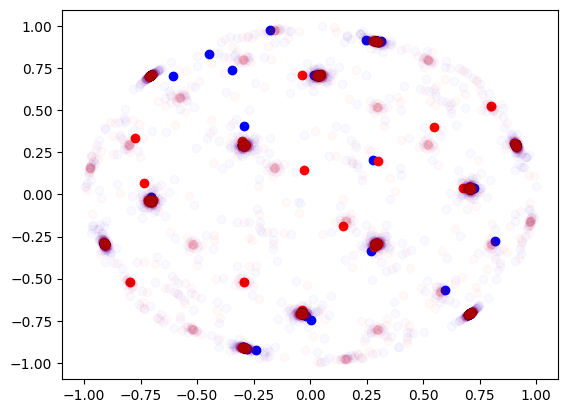

0 2


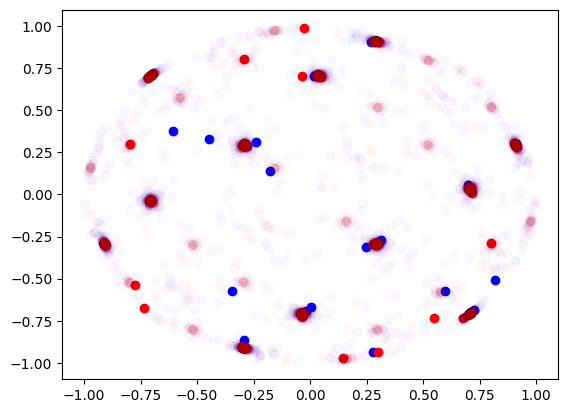

1 2


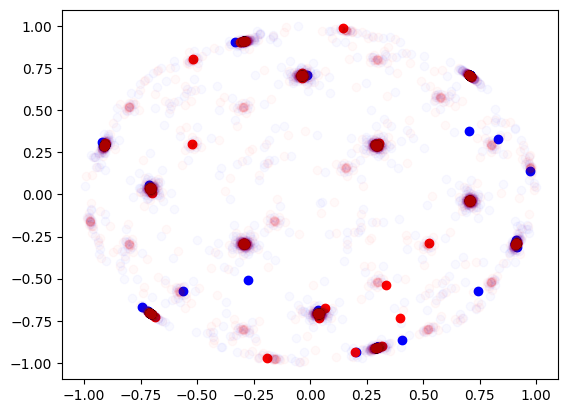

In [111]:
for i, j in list(product(range(irrep_d), repeat=2)):
    if i >= j:
        continue
    print(i, j)
    plt.scatter(b[:,i].tolist(), b[:,j].tolist(), alpha=1., c='b')
    plt.scatter(c[:,i].tolist(), c[:,j].tolist(), alpha=1., c='r')
    plt.scatter(full_b[:,i].tolist(), full_b[:,j].tolist(), alpha=0.01, c='b')
    plt.scatter(full_c[:,i].tolist(), full_c[:,j].tolist(), alpha=0.01, c='r')
    plt.show()

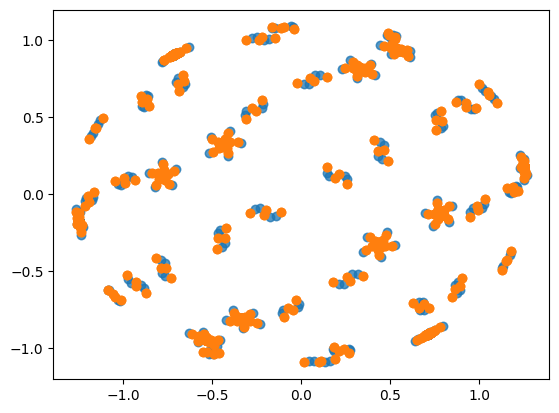

In [94]:
axis1 = t.randn((irrep_d ,1))
axis2 = t.randn((irrep_d, 1))
plt.scatter(full_c @ axis1, full_c @ axis2, alpha=0.5)
plt.scatter(full_b @ axis1, full_b @ axis2, alpha=1.0)
plt.show()

### b_i and c_i are clustered

In [65]:
from sklearn.cluster import KMeans

def cluster(vecs, num_seeds=30, thresh=1):
    n_clusters = 1
    losses = []
    while not losses or losses[-1] > thresh:
        n_clusters += 1
        kmeans = min(
            (KMeans(n_clusters=n_clusters, random_state=seed).fit(vecs.numpy())
            for seed in range(num_seeds)),
            key=lambda k: k.inertia_
        )
        losses.append(kmeans.inertia_)
        if len(losses) > 1 and losses[-2] / losses[-1] > 10:
            break
        print(n_clusters, losses[-1])
    return kmeans, n_clusters, losses

In [66]:
b_kmeans, b_clusters, b_losses = cluster(full_b)
c_kmeans, c_clusters, c_losses = cluster(full_c)
b_labels, c_labels = b_kmeans.labels_, c_kmeans.labels_
b_mean, c_mean = b_kmeans.cluster_centers_, c_kmeans.cluster_centers_
b_clusters, c_clusters

2 5105.80126953125
3 4618.27490234375
4 4034.87255859375
5 3659.837158203125
6 3308.856201171875
7 2959.600341796875
8 2727.15283203125
9 2468.3173828125
10 2375.748046875
11 2273.279541015625
12 2153.5908203125
13 2040.454833984375
14 1966.9747314453125
15 1859.4261474609375
16 1778.8380126953125
17 1683.32861328125
18 1594.900390625
19 1516.9373779296875
20 1439.2412109375
21 1348.6456298828125
22 1270.04150390625
23 1184.2392578125
24 1108.0826416015625
25 1034.001708984375
26 957.15625
27 888.580078125
28 819.4691772460938
29 753.3010864257812
30 695.1144409179688
31 635.0565185546875
32 576.24560546875
33 520.4964599609375
34 460.0614318847656
35 399.8534240722656
36 341.3517761230469
37 315.9276428222656
38 289.6000671386719
39 263.08929443359375
40 236.7376251220703


KeyboardInterrupt: 

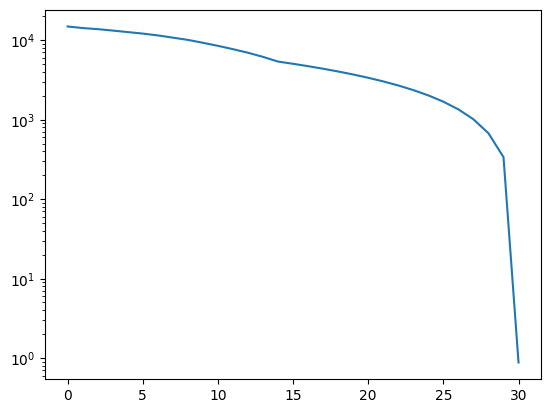

In [ ]:
plt.plot(b_losses)
plt.yscale('log')
plt.show()

In [ ]:
b_parts = []
c_parts = []
for i in range(b_clusters):
    c_set = set(c_labels[b_labels == i].tolist())
    done = False
    for j in range(len(c_parts)):
        if len(c_set & c_parts[j]) > 0:
            c_parts[j] = c_set.union(c_parts[j])
            b_parts[j].add(i)
            done = True
            break
    if not done:
        c_parts.append(c_set)
        b_parts.append({i})
    print(f'b={i}, c={sorted(c_set)}')

print(b_parts)
print(c_parts)

b_parts = list(map(list, b_parts))
c_parts = list(map(list, c_parts))

b=0, c=[2, 4, 6, 7, 8, 11, 13, 15, 16, 18, 19, 20, 21, 22, 25, 29]
b=1, c=[0, 1, 3, 5, 9, 10, 12, 14, 17, 23, 24, 26, 27, 28, 30, 31]
b=2, c=[0, 1, 3, 5, 9, 10, 12, 14, 17, 23, 24, 26, 27, 28, 30, 31]
b=3, c=[2, 4, 6, 7, 8, 11, 13, 15, 16, 18, 19, 20, 21, 22, 25, 29]
b=4, c=[0, 1, 3, 5, 9, 10, 12, 14, 17, 23, 24, 26, 27, 28, 30, 31]
b=5, c=[0, 1, 3, 5, 9, 10, 12, 14, 17, 23, 24, 26, 27, 28, 30, 31]
b=6, c=[0, 1, 3, 5, 9, 10, 12, 14, 17, 23, 24, 26, 27, 28, 30, 31]
b=7, c=[0, 1, 3, 5, 9, 10, 12, 14, 17, 23, 24, 26, 27, 28, 30, 31]
b=8, c=[2, 4, 6, 7, 8, 11, 13, 15, 16, 18, 19, 20, 21, 22, 25, 29]
b=9, c=[2, 4, 6, 7, 8, 11, 13, 15, 16, 18, 19, 20, 21, 22, 25, 29]
b=10, c=[2, 4, 6, 7, 8, 11, 13, 15, 16, 18, 19, 20, 21, 22, 25, 29]
b=11, c=[2, 4, 6, 7, 8, 11, 13, 15, 16, 18, 19, 20, 21, 22, 25, 29]
b=12, c=[2, 4, 6, 7, 8, 11, 13, 15, 16, 18, 19, 20, 21, 22, 25, 29]
b=13, c=[2, 4, 6, 7, 8, 11, 13, 15, 16, 18, 19, 20, 21, 22, 25, 29]
b=14, c=[0, 1, 3, 5, 9, 10, 12, 14, 17, 23, 24, 26, 27, 28

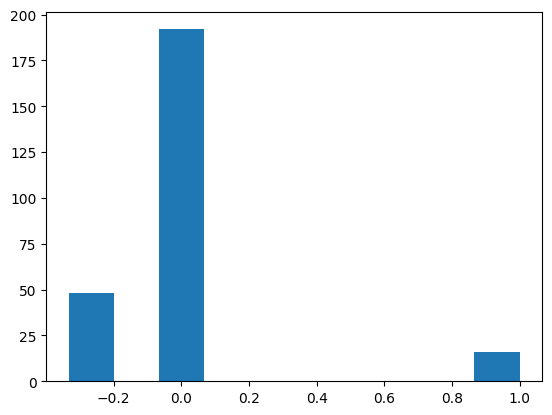

In [31]:
plt.hist((b_mean[b_parts[0]] @ b_mean[b_parts[0]].T).flatten())
plt.show()

In [35]:
# Check that irrep is G-action on each partition of b's clusters
for b_part in b_parts:
    T = einops.einsum(b_mean[b_part], irrep, b_mean[b_part], 'm1 d1, G d1 d2, m2 d2 -> G m1 m2')
    T = (T > 1 - 1e-2).astype(float)
    assert (T.sum(axis=1) == 1).all() and (T.sum(axis=2) == 1).all()
    for i, j in product(range(T.shape[0]), repeat=2):
        if i >= j:
            continue
        assert not (T[i] == T[j]).all()

In [36]:
# Check that {b_i} = {-c_i}
for b_part, c_part in zip(b_parts, c_parts):
    S = b_mean[b_part] @ -c_mean[c_part].T
    S = (S > 1 - 1e-2).astype(float)
    assert (S.sum(axis=0) == 1).all() and (S.sum(axis=1) == 1).all()

### Activations are clustered

In [77]:
embedding_left = model.embedding_left.squeeze(0)
embedding_right = model.embedding_right.squeeze(0)
linear = model.linear.squeeze(0)
unembedding = model.unembedding.squeeze(0).T
# There's a degree of freedom with embedding/unembedding norm.
# Rescale so that each unembedding column is norm 1
u_norm = unembedding.norm(dim=0)
unembedding = unembedding / u_norm
linear = linear * u_norm

In [78]:
N = len(group)
inputs = t.tensor(list(product(range(N), repeat=2)), device=device)
l_in, r_in = inputs[..., 0], inputs[..., 1]
l_onehot = F.one_hot(l_in, num_classes=N).float()
r_onehot = F.one_hot(r_in, num_classes=N).float()
l_embed = einops.einsum(l_onehot, embedding_left, 'batch group, group embed -> batch embed')
r_embed = einops.einsum(r_onehot, embedding_right, 'batch group, group embed -> batch embed')
l_act = einops.einsum(l_embed, linear, 'batch embed, embed hid -> batch hid')
r_act = einops.einsum(r_embed, linear, 'batch embed, embed hid -> batch hid')
l_act = l_act[:, irrep_idxs]
r_act = r_act[:, irrep_idxs]

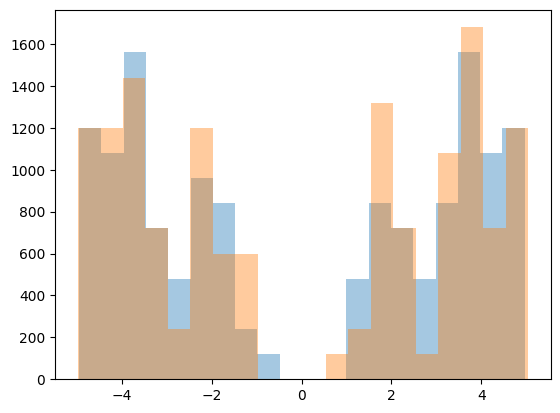

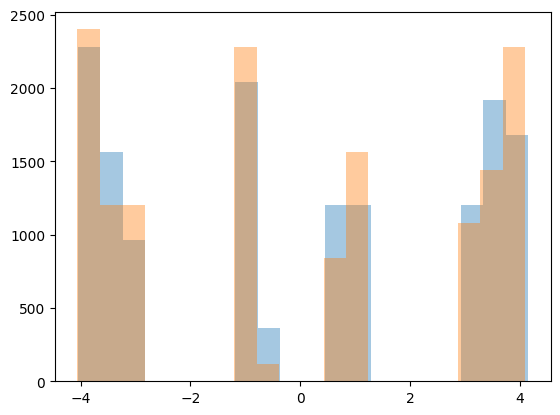

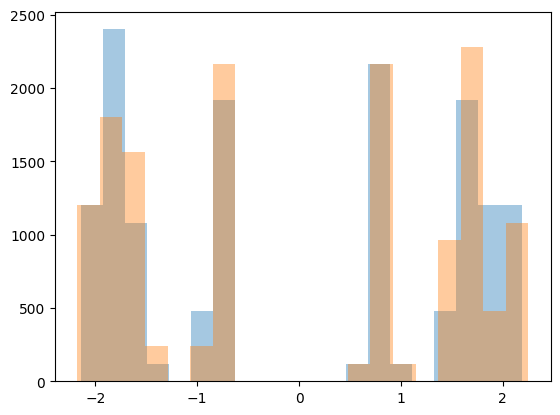

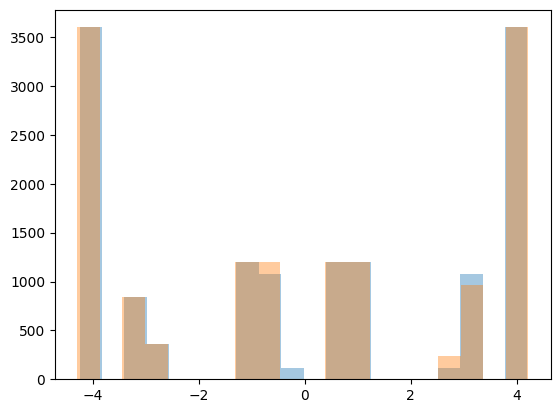

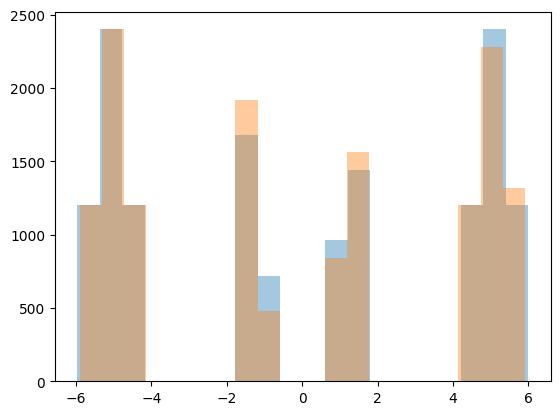

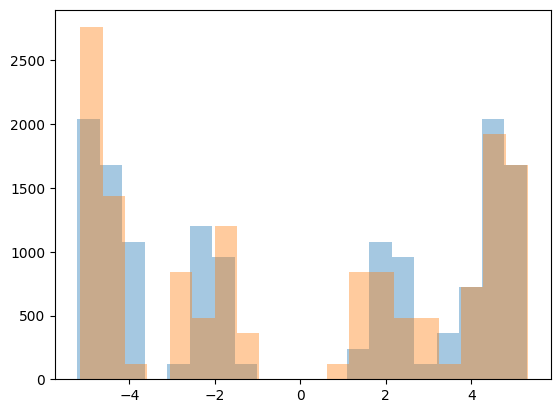

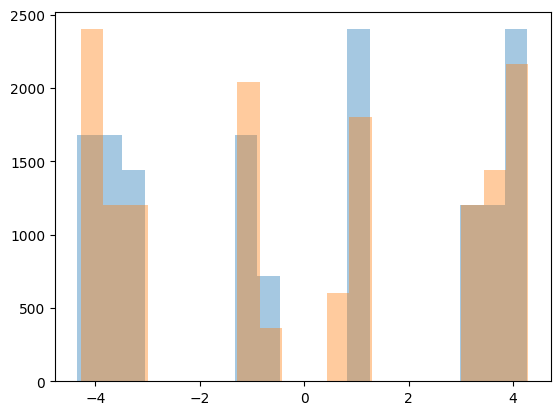

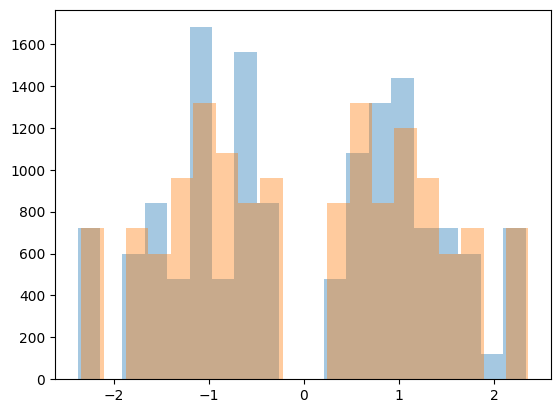

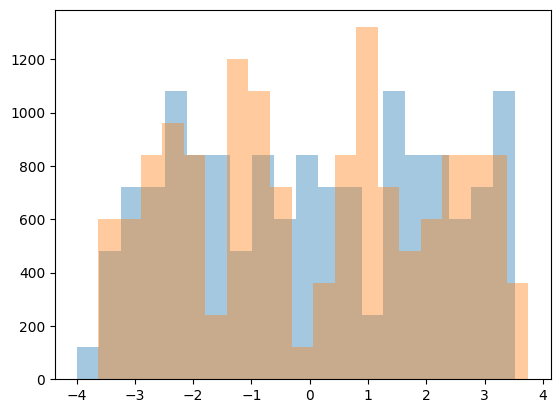

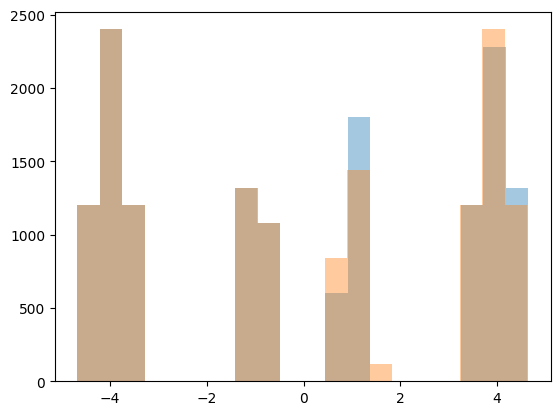

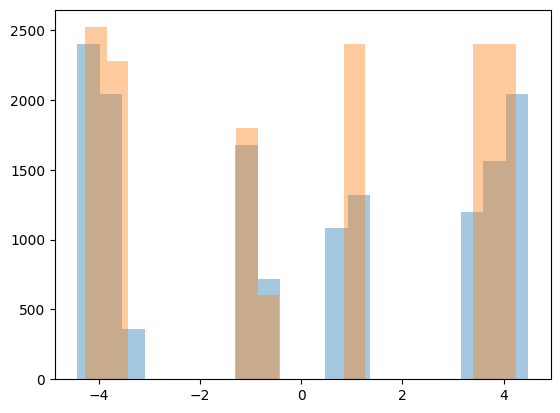

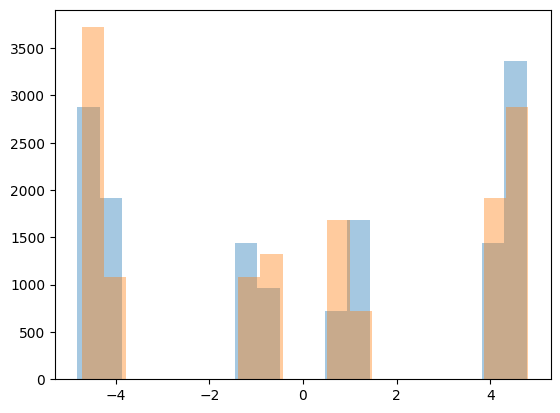

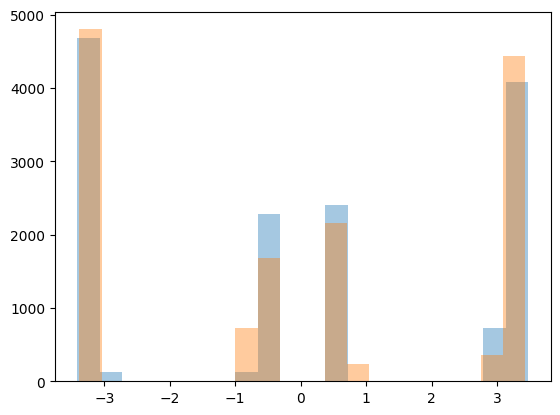

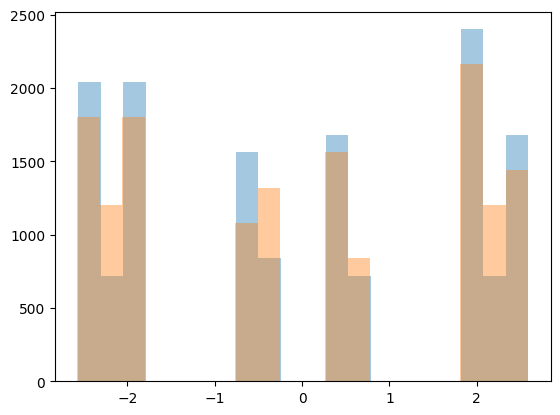

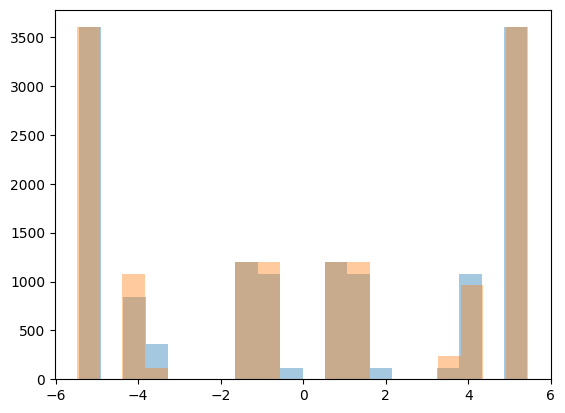

In [79]:
for i in range(15):
    plt.hist(l_act[:,i].tolist(), alpha=0.4, bins=20)
    plt.hist(r_act[:,i].tolist(), alpha=0.4, bins=20)
    plt.show()

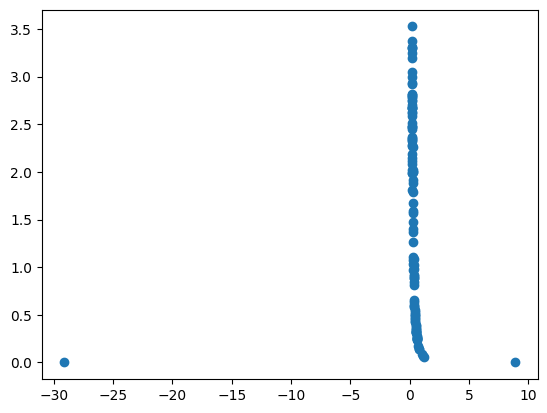

In [70]:
plt.scatter(coef.tolist(), l_act.max(dim=0)[0].tolist())
plt.show()

In [ ]:
big_neurons = (l_act.max(dim=0)[0] > 15).nonzero()

In [ ]:
b_part1

[0, 1, 3, 4, 9]

In [ ]:
b_labels[big_neurons]

array([[4],
       [5],
       [6],
       [2],
       [6],
       [4],
       [2],
       [6],
       [0],
       [0],
       [6],
       [2],
       [5],
       [5],
       [4],
       [4],
       [2],
       [4],
       [0],
       [5],
       [6],
       [0],
       [0]], dtype=int32)

In [ ]:
def ablate_loss(ln, rn, un):
    ablate_model = copy.deepcopy(model)
    ablate_model.linear.data = t.eye(ln.shape[1]).unsqueeze(0)
    ablate_model.embedding_left.data = ln.unsqueeze(0)
    ablate_model.embedding_right.data = rn.unsqueeze(0)
    ablate_model.unembedding.data = un.unsqueeze(0).mT
    return test_loss(ablate_model.to(device), data)

In [ ]:
big_mask = l_act.max(dim=0)[0] > 15
small_mask = l_act.max(dim=0)[0] < 3
part1_mask = t.tensor([i in b_part1 for i in b_labels], device=device)
part2_mask = t.tensor([i in b_part2 for i in b_labels], device=device)

In [ ]:
print(ablate_loss(irrep_lneurons, irrep_rneurons, irrep_uneurons))
print(ablate_loss(irrep_lneurons[:,big_mask], irrep_rneurons[:,big_mask], irrep_uneurons[:,big_mask]))
print(ablate_loss(irrep_lneurons[:,small_mask], irrep_rneurons[:,small_mask], irrep_uneurons[:,small_mask]))
print(ablate_loss(irrep_lneurons[:,part1_mask], irrep_rneurons[:,part1_mask], irrep_uneurons[:,part1_mask]))
print(ablate_loss(irrep_lneurons[:,part2_mask], irrep_rneurons[:,part2_mask], irrep_uneurons[:,part2_mask]))
print(ablate_loss(irrep_lneurons[:,part1_mask & big_mask], irrep_rneurons[:,part1_mask & big_mask], irrep_uneurons[:,part1_mask & big_mask]))
print(ablate_loss(irrep_lneurons[:,part1_mask & small_mask], irrep_rneurons[:,part1_mask & small_mask], irrep_uneurons[:,part1_mask & small_mask]))
print(ablate_loss(irrep_lneurons[:,part2_mask & big_mask], irrep_rneurons[:,part2_mask & big_mask], irrep_uneurons[:,part2_mask & big_mask]))
print(ablate_loss(irrep_lneurons[:,part2_mask & small_mask], irrep_rneurons[:,part2_mask & small_mask], irrep_uneurons[:,part2_mask & small_mask]))


{'G0_loss': tensor([0.8658]), 'G0_acc': tensor([0.5001])}
{'G0_loss': tensor([1.4867]), 'G0_acc': tensor([0.3433])}
{'G0_loss': tensor([4.2793]), 'G0_acc': tensor([0.3035])}
{'G0_loss': tensor([3.3410]), 'G0_acc': tensor([0.1060])}
{'G0_loss': tensor([2.6429]), 'G0_acc': tensor([0.1717])}
{'G0_loss': tensor([3.5448]), 'G0_acc': tensor([0.0409])}
{'G0_loss': tensor([4.5008]), 'G0_acc': tensor([0.0628])}
{'G0_loss': tensor([3.2302]), 'G0_acc': tensor([0.0570])}
{'G0_loss': tensor([4.5770]), 'G0_acc': tensor([0.0439])}


In [ ]:
ablate_loss(10*irrep_lneurons, 10*irrep_rneurons, 10*irrep_uneurons)

{'G0_loss': tensor([29.3090]), 'G0_acc': tensor([0.5001])}

In [ ]:
irrep_lneurons.shape

torch.Size([120, 52])

In [ ]:
big_mask.sum(), small_mask.sum() 

(tensor(23), tensor(25))